**2.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

We first code the function `backtracking_line_search(f, grad_f, v, delta_v, alpha = 0.5, beta = 0.9)`, which performs backtracking line search on a function `f` whose gradient `grad_f` is given.

In [ ]:
def backtracking_line_search(f, grad_f, v, delta_v, alpha = 0.5, beta = 0.9):
    step = 1

    v_new = v + step * delta_v
    f_v_new = f(v_new)

    while f_v_new >= f(v) + alpha * step * (grad_f(v).T @ delta_v):
        step *= beta
        v_new = v + step * delta_v
        f_v_new = f(v_new)
    return step

We define three functions `objective(Q, p, A, b, t, v)`, `gradient(Q, p, A, b, t, v)` and `hessian(Q, p, A, b, t, v)` which code the objective function for the barrier method, the gradient of this function, and its hessian matrix.

In [ ]:
def f0(Q, p, v):
  return v.T @ Q @ v + p.T @ v

def objective(Q, p, A, b, t, v):
  aux = b - A @ v
  if np.any(aux <= 0):
      return float("inf")
  return t * f0(Q, p, v) - np.sum(np.log(aux))

def gradient(Q, p, A, b, t, v):
  return t * (2 * Q @ v + p) + A.T @ (1 / (b - A @ v))

def hessian(Q, p, A, b, t, v):
  return 2 * t * Q + A.T @ np.diag(1 / (b - A @ v)**2) @ A

We can then code the centering step function `centering_step(Q, p, A, b, t, v0, eps)` by combining the previously written functions.

In [ ]:
def centering_step(Q, p, A, b, t, v0, eps):

  objective_fun = lambda v: objective(Q, p, A, b, t, v)
  gradient_fun = lambda v: gradient(Q, p, A, b, t, v)

  v = np.copy(v0)
  v_seq = [v]

  number_steps = 0

  while True:
    number_steps += 1

    grad_v = gradient_fun(v)
    delta_v = -np.linalg.inv(hessian(Q, p, A, b, t, v)) @ grad_v
    lambda_2 = -grad_v.T @ delta_v

    if lambda_2 / 2 < eps:
      break

    step = backtracking_line_search(objective_fun, gradient_fun, v, delta_v)
    v = v + step * delta_v
    v_seq.append(v)

  return v_seq, number_steps

And we then code `barr_method(Q, p, A, b, v0, eps = 1e-9, mu = 2)`, for which we added the argument `mu` for the experiments of the next question.

In [ ]:
def barr_method(Q, p, A, b, v0, eps = 1e-4, mu = 2):
    number_newton_iterations = 0

    v_seq = [np.copy(v0)]
    t = 1
    m = A.shape[0]

    while m / t > eps:
        v, number_steps = centering_step(Q, p, A, b, t, v_seq[-1], eps = 1e-4)
        v = v[-1]
        v_seq.append(v)
        number_newton_iterations += number_steps

        t *= mu
    return v_seq, number_newton_iterations

**3.**
Now, we write a function `generate_parameters(n, d, l = 10)` which generates `X, y, Q, p, A, b, v0`: for `X` and `y`, we draw them from a normal distribution, and for the rest, we use the results of the first question.

In [ ]:
def generate_parameters(n, d, l = 10):

    X = 2 * np.random.randn(n, d)

    w = np.random.randn(d)
    w = w / np.linalg.norm(w)

    y = X @ w + np.random.randn(n)

    Q = 0.5 * np.eye(n)
    p = - y
    A = np.concatenate((X.T, -X.T), axis = 0)
    b = l * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

We can now observe the results for several values of `mu`.

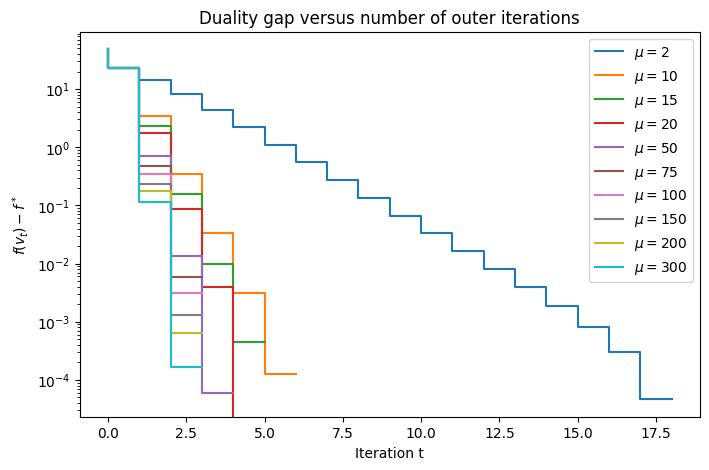

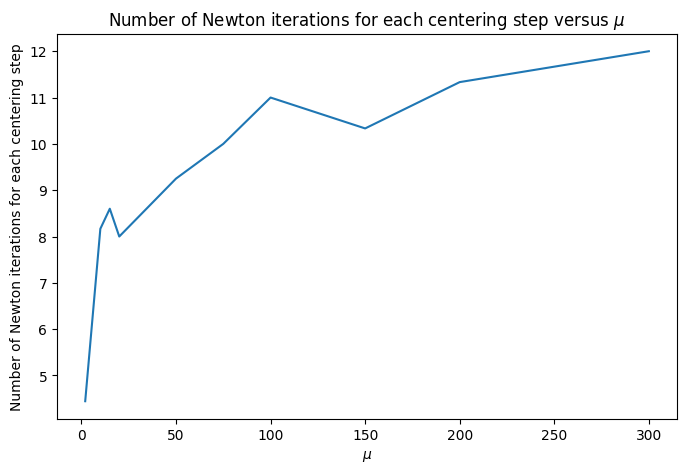

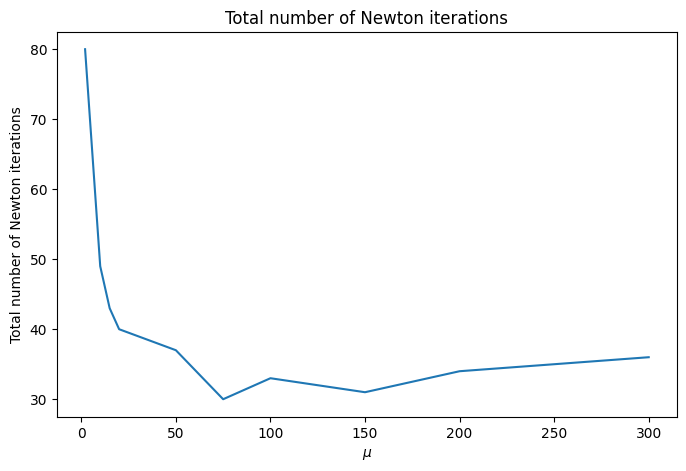

In [ ]:
mu_list = [2, 10, 15, 20, 50, 75, 100, 150, 200, 300]

n, d = 50, 100
l = 10
X, y, Q, p, A, b, v0 = generate_parameters(n, d, l)
eps = 1e-3

results = [barr_method(Q, p, A, b, v0, eps, mu) for mu in mu_list]
avg_number_newton_iterations = [x[1] / (len(x[0]) - 1) for x in results]
total_number_newton_iterations = [x[1] for x in results]
results = [x[0] for x in results]

f_values = [[f0(Q, p, v) for v in results[i]] for i in range(len(results))]
f_star = min([min(x) for x in f_values])

plt.figure(figsize = (8, 5))

for i in range(len(results)):
  plt.step(range(len(f_values[i])), f_values[i] - f_star, label = r"$\mu =$" + str(mu_list[i]))

plt.semilogy()
plt.xlabel("Iteration t")
plt.ylabel(r"$f(v_t) - f^*$")
plt.title("Duality gap versus number of outer iterations")
plt.legend()
plt.show()


plt.figure(figsize = (8, 5))

plt.plot(mu_list, avg_number_newton_iterations)
plt.xlabel(r"$\mu$")
plt.ylabel("Number of Newton iterations for each centering step")
plt.title("Number of Newton iterations for each centering step versus $\mu$")
plt.show()



plt.figure(figsize = (8, 5))

plt.plot(mu_list, total_number_newton_iterations)
plt.xlabel(r"$\mu$")
plt.ylabel("Total number of Newton iterations")
plt.title("Total number of Newton iterations")
plt.show()

We see in the first graph that the smaller $\mu$ is, the more outer iterations are required to achieve a given precision.

However, for small values of $\mu$, less inner Newton iterations are required at each centering step.

Therefore there is a trade-off between the number of inner and outer iterations.

In this specific case, we see that most values of $\mu$ lead to a total number of Newton steps between $20$ and $40$. $\mu = 75$ seems quite good here.

Note however that in general, $\mu$ is taken between $10$ and $20$.